### Imports and functions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from google.cloud import storage

# client = storage.Client()
# for blob in client.list_blobs('climateai_data_repository', prefix='tmp/internal_variability'):
#   print(str(blob))

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
from src.LE_LoadAndMerge import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from copy import deepcopy

In [4]:
def extreme_mean_allregions(args):
    regions = [USwest,europe,australia,tropics]
    dss = []
    for r in regions:
        internal = r.extreme_internal_variability(**args)
        internal = internal.expand_dims('region')
        dss.append(internal)
    regions = ['USwest','europe','australia','tropics']
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    return final_dataset

In [73]:
def internal_mean_allregions():
    regions = [USwest,europe,australia,tropics]
    dss = []
    for r in regions:
        internal = r.compute_internal_variability_mean()
        internal = internal.expand_dims('region')
        dss.append(internal)
    regions = ['USwest','europe','australia','tropics']
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    return final_dataset

In [6]:
def internal_max_allregions():
    regions = [USwest,europe,australia,tropics]
    dss = []
    for r in regions:
        internal = r.compute_internal_variability_max()
        internal = internal.expand_dims('region')
        dss.append(internal)
    regions = ['USwest','europe','australia','tropics']
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    return final_dataset

In [7]:
def extreme_max_allregions():
    regions = [USwest,europe,australia,tropics]
    dss = []
    for r in regions:
        internal = r.extreme_internal_variability_max(return_period=10)
        internal = internal.expand_dims('region')
        dss.append(internal)
    regions = ['USwest','europe','australia','tropics']
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    return final_dataset

In [29]:
def compute_scenario_allregions():
    regions = ['USwest','europe','australia','tropics']
    dss = []
    for r in regions:
        exec('scenario = ssp126_'+r+'.compute_scenario(ssp126_'+r+',ssp245_'+r+',ssp370_'+r+',ssp585_'+r+')')
        scenario = scenario.expand_dims('region')
        dss.append(scenario)
    final_dataset = xr.concat(dss,dim='region')
    final_dataset = final_dataset.assign_coords({'region':regions})
    
    return final_dataset

### Load Datasets

In [63]:
# settings 
#for temp
variable = 'tas'
models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR','EC-Earth3'] 

#for precip - still having issues getting EC-Earth data 
# variable = 'pr'
# models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR'] 

In [64]:
USwest = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable=variable, granularity='day', lat=37.7, lon=-122.4,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [65]:
europe = MultiModelLargeEnsemble(models=models,scenario='ssp585',
                                 variable=variable, granularity='day', lat=51,lon=10.5,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [66]:
australia = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable=variable, granularity='day', lat=-25.2,lon=133.7,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

In [67]:
tropics = MultiModelLargeEnsemble(models=models,scenario='ssp585',
                                 variable=variable, granularity='day', lat=3.9,lon=-53.1,
                                 bucket='climateai_data_repository', 
                                 path='tmp/internal_variability',
                                 load=True,single_member=False)

### Variabilitys without scenario

In [74]:
# original internal var calculation 
internal_mean = internal_mean_allregions()

In [75]:
internal_mean

<xarray.Dataset>
Dimensions:            (time: 86, model: 5, region: 4, member: 58)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    member_id          (member, model) object 'r16i1p2f1' 1.0 ... nan 'r3i1p1f1'
  * region             (region) <U9 'USwest' 'europe' 'australia' 'tropics'
Data variables: (12/17)
    tas_ref            (region, model) float32 15.79 14.98 16.45 ... 27.69 26.09
    tas                (region, time, member, model) float32 nan nan ... nan nan
    model_le           (region, time) float32 nan nan nan nan ... nan nan nan
    internal_mean_le   (region, time) float32 nan nan nan nan ... nan nan nan
    internal_var_le    (region, time) float32 nan nan nan nan ... nan nan nan
    total_le           (region, time) float32 nan nan nan nan ... nan nan nan
    ...                 ...
    internal_var_fit   (region) float64 0.0002374 0.0003806 0.0004129 0.0008531
    model_fit          (region, time) float32 nan nan nan nan ... nan nan nan
    total_fit          (region, time) float32 nan nan nan nan ... nan nan nan
    internal_fit_frac  (region, time) float32 nan nan nan nan ... nan nan nan
    model_fit_frac     (region, time) float32 nan nan nan nan ... nan nan nan
    total_direct_fit   (region, time) float32 nan nan nan nan ... nan nan nan

In [17]:
# internal using yearly max
internal_max = internal_max_allregions()

In [21]:
# internal extreme 
extreme_mean = extreme_mean_allregions(args = {'return_period':10,
                                    'coarsen':1,
                                    'conseq_days':1,
                                    'rolling_average':10,
                                    'hist_slice':slice('1995','2014'),
                                    'postprocess':True
                                    }
                           )

In [22]:
# internal extreme using max data 
extreme_max = extreme_max_allregions()

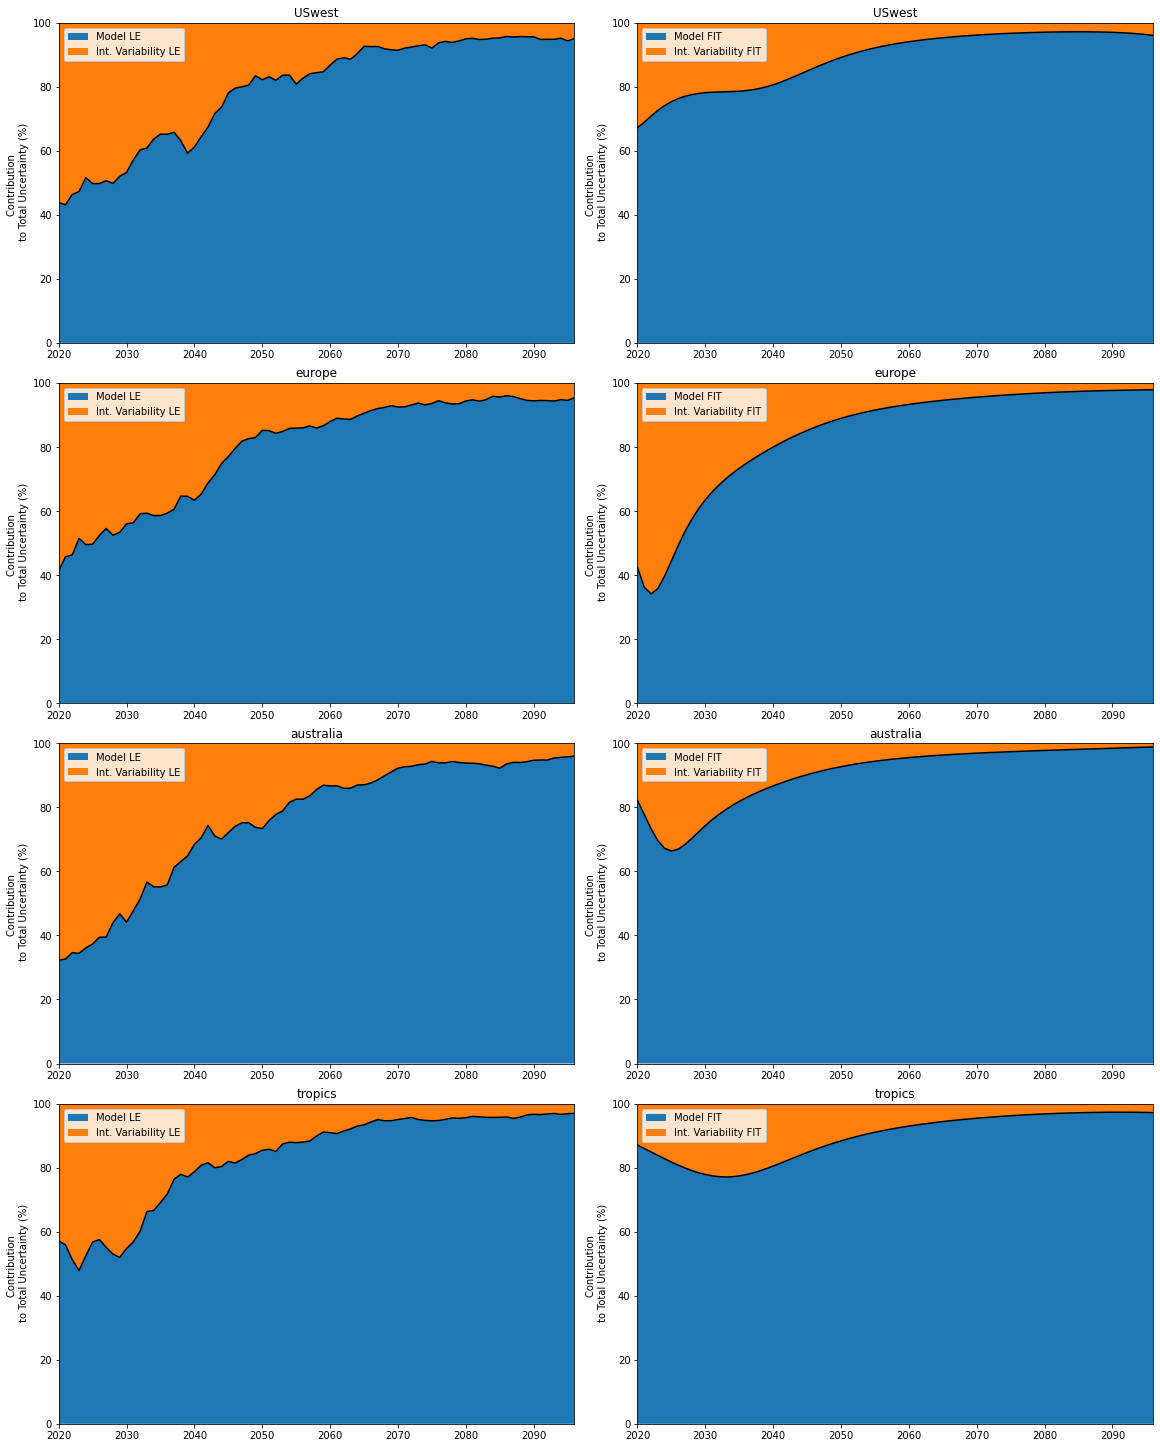

In [23]:
# INTERNAL MEAN
fig,ax = plt.subplots(nrows=4,ncols=2, constrained_layout=True,figsize=(16,20))

regions = ['USwest','europe','australia','tropics']
axes = [ax[0,0],ax[1,0],ax[2,0],ax[3,0]]
for axis,region in zip(axes,regions):
    x=internal_mean.sel(region=region).time
    y=internal_mean.sel(region=region).model_le_frac
    axis.fill_between(x,y,label='Model LE')
    axis.plot(internal_mean.sel(region=region).time,internal_mean.sel(region=region).model_le_frac,color='k')
    axis.fill_between(x,y,100,label='Int. Variability LE')
    axis.set_ylim(0,100)
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[5],x[-5])
    
axes = [ax[0,1],ax[1,1],ax[2,1],ax[3,1]]
for axis,region in zip(axes,regions):
    x=internal_mean.sel(region=region).time
    y=internal_mean.sel(region=region).model_fit_frac
    axis.fill_between(x,y,label='Model FIT')
    axis.plot(internal_mean.sel(region=region).time,internal_mean.sel(region=region).model_fit_frac,color='k')
    axis.fill_between(x,y,100,label='Int. Variability FIT')
    axis.set_ylim(0,100)
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[5],x[-5])

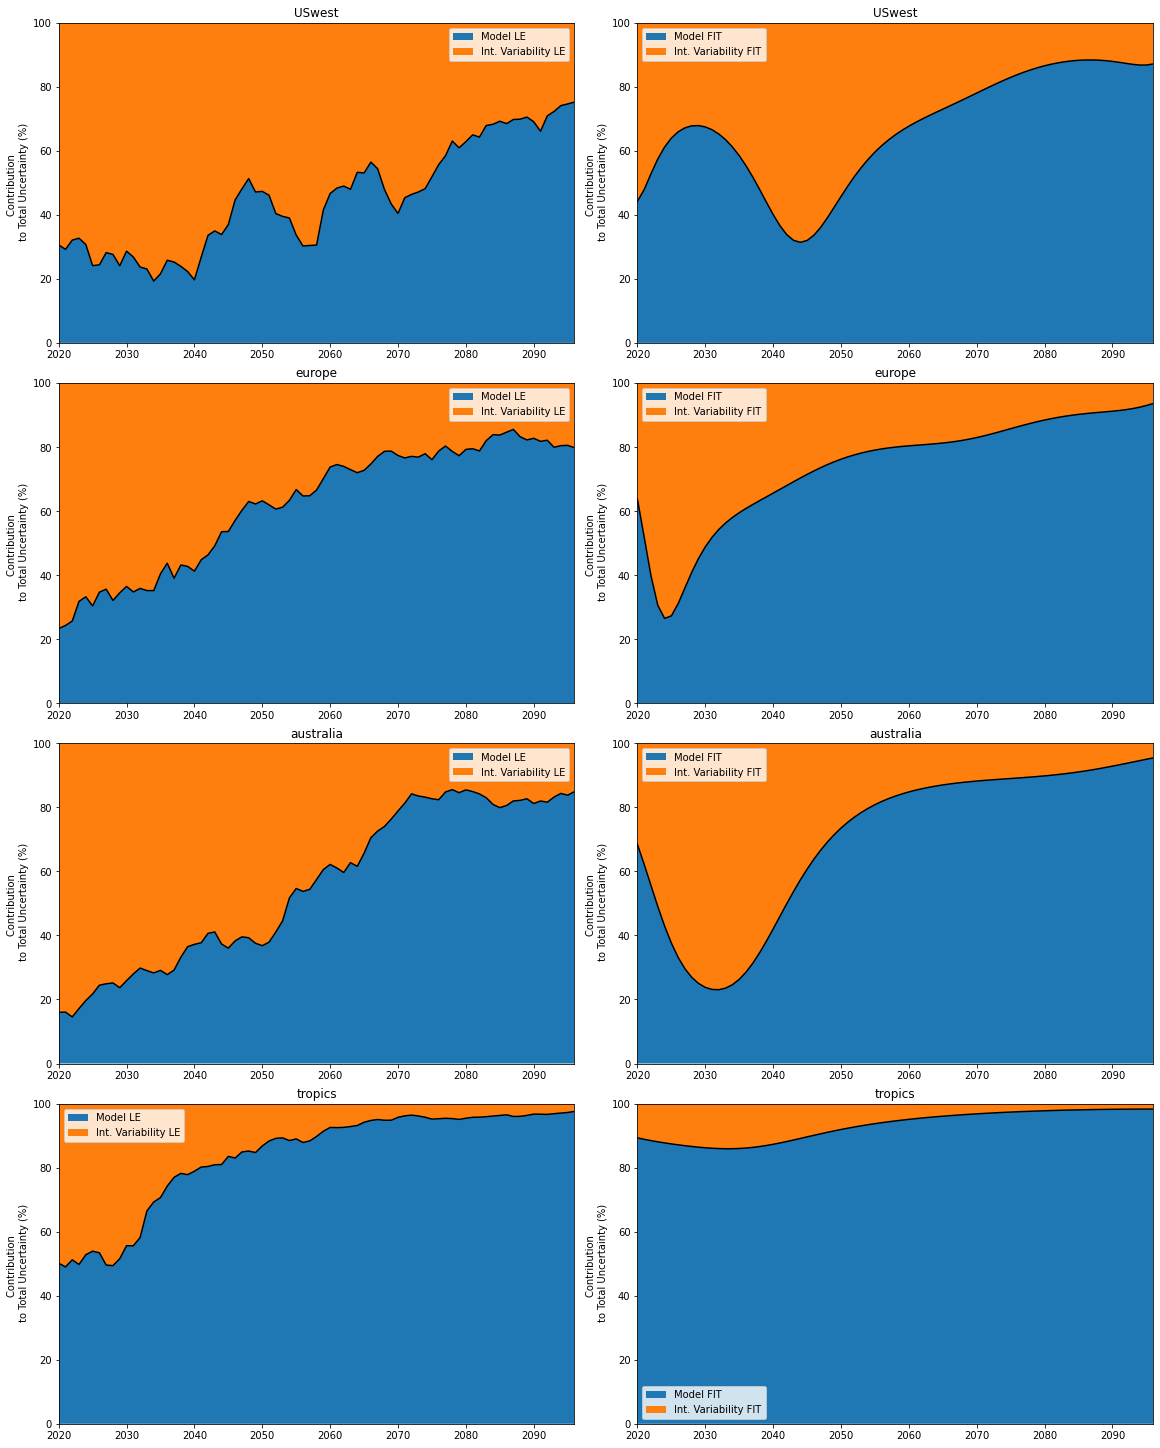

In [24]:
# INTERNAL YEARLY MAX 
fig,ax = plt.subplots(nrows=4,ncols=2, constrained_layout=True,figsize=(16,20))

regions = ['USwest','europe','australia','tropics']
axes = [ax[0,0],ax[1,0],ax[2,0],ax[3,0]]
for axis,region in zip(axes,regions):
    x=internal_max.sel(region=region).time
    y=internal_max.sel(region=region).model_le_frac
    axis.fill_between(x,y,label='Model LE')
    axis.plot(internal_max.sel(region=region).time,internal_max.sel(region=region).model_le_frac,color='k')
    axis.fill_between(x,y,100,label='Int. Variability LE')
    axis.set_ylim(0,100)
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[5],x[-5])
    
axes = [ax[0,1],ax[1,1],ax[2,1],ax[3,1]]
for axis,region in zip(axes,regions):
    x=internal_max.sel(region=region).time
    y=internal_max.sel(region=region).model_fit_frac
    axis.fill_between(x,y,label='Model FIT')
    axis.plot(internal_max.sel(region=region).time,internal_max.sel(region=region).model_fit_frac,color='k')
    axis.fill_between(x,y,100,label='Int. Variability FIT')
    axis.set_ylim(0,100)
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[5],x[-5])

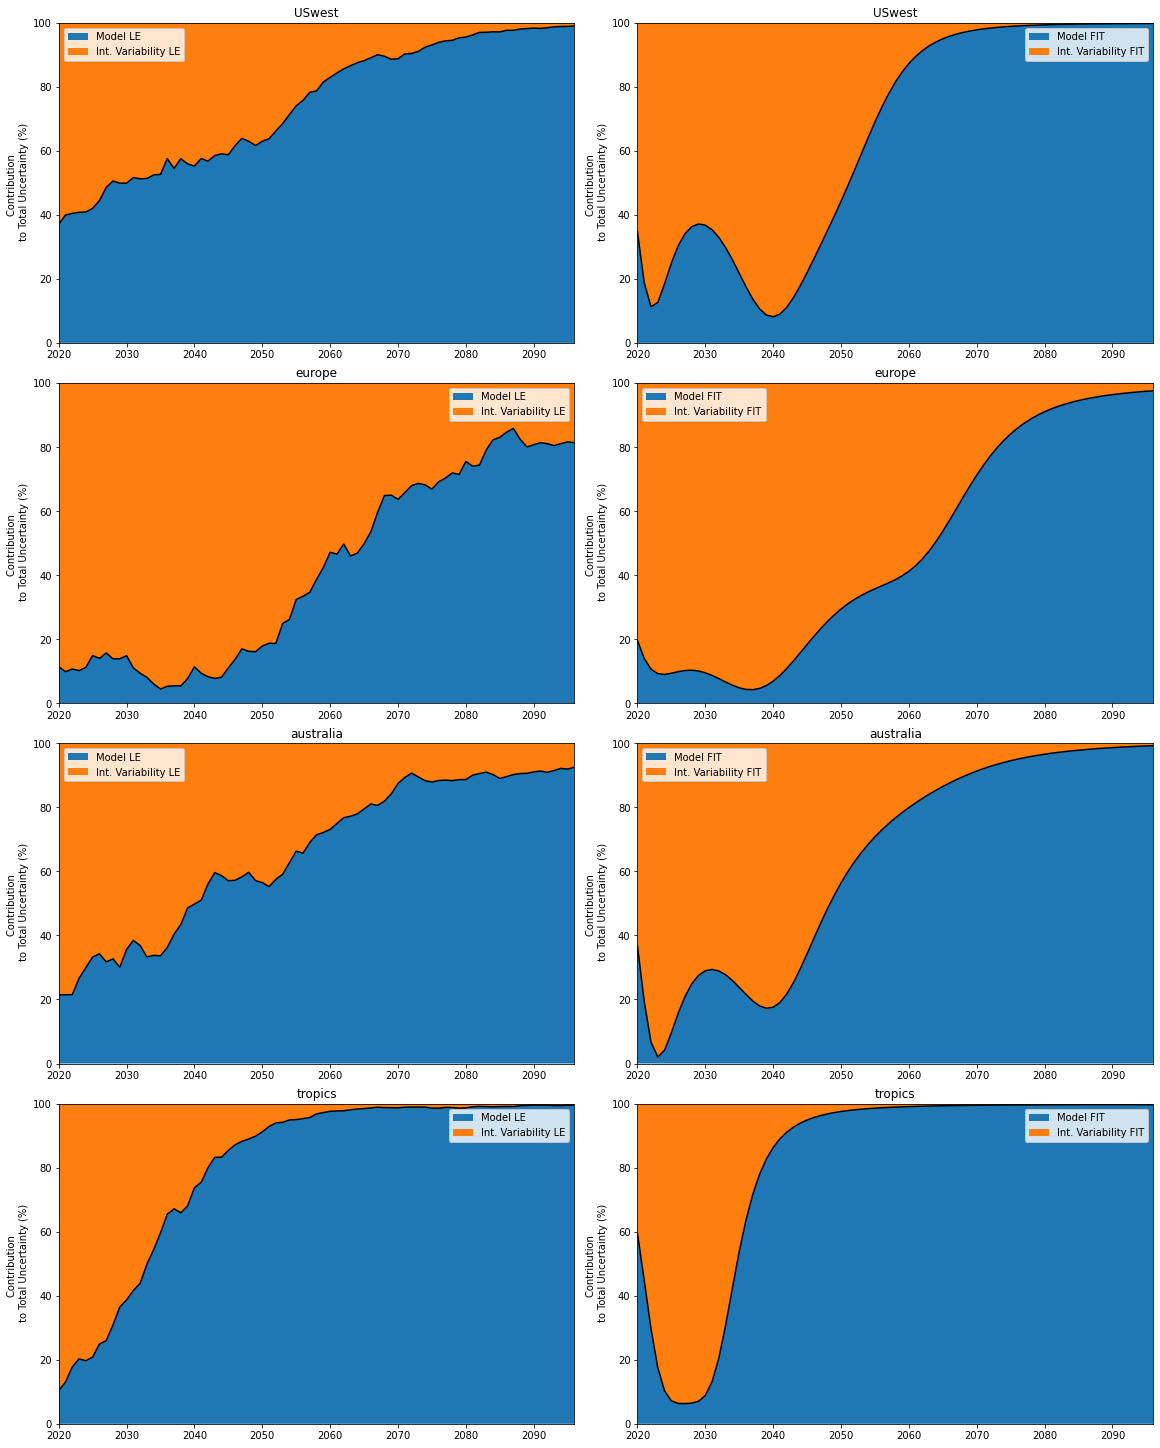

In [25]:
# INTERNAL EXTREME MEAN 
fig,ax = plt.subplots(nrows=4,ncols=2, constrained_layout=True,figsize=(16,20))

regions = ['USwest','europe','australia','tropics']
axes = [ax[0,0],ax[1,0],ax[2,0],ax[3,0]]
for axis,region in zip(axes,regions):
    x=extreme_mean.sel(region=region).time
    y=extreme_mean.sel(region=region).model_le_frac
    axis.fill_between(x,y,label='Model LE')
    axis.plot(extreme_mean.sel(region=region).time,extreme_mean.sel(region=region).model_le_frac,color='k')
    axis.fill_between(x,y,100,label='Int. Variability LE')
    axis.set_ylim(0,100)
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[5],x[-5])
    
axes = [ax[0,1],ax[1,1],ax[2,1],ax[3,1]]
for axis,region in zip(axes,regions):
    x=extreme_mean.sel(region=region).time
    y=extreme_mean.sel(region=region).model_fit_frac
    axis.fill_between(x,y,label='Model FIT')
    axis.plot(extreme_mean.sel(region=region).time,extreme_mean.sel(region=region).model_fit_frac,color='k')
    axis.fill_between(x,y,100,label='Int. Variability FIT')
    axis.set_ylim(0,100)
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[5],x[-5])

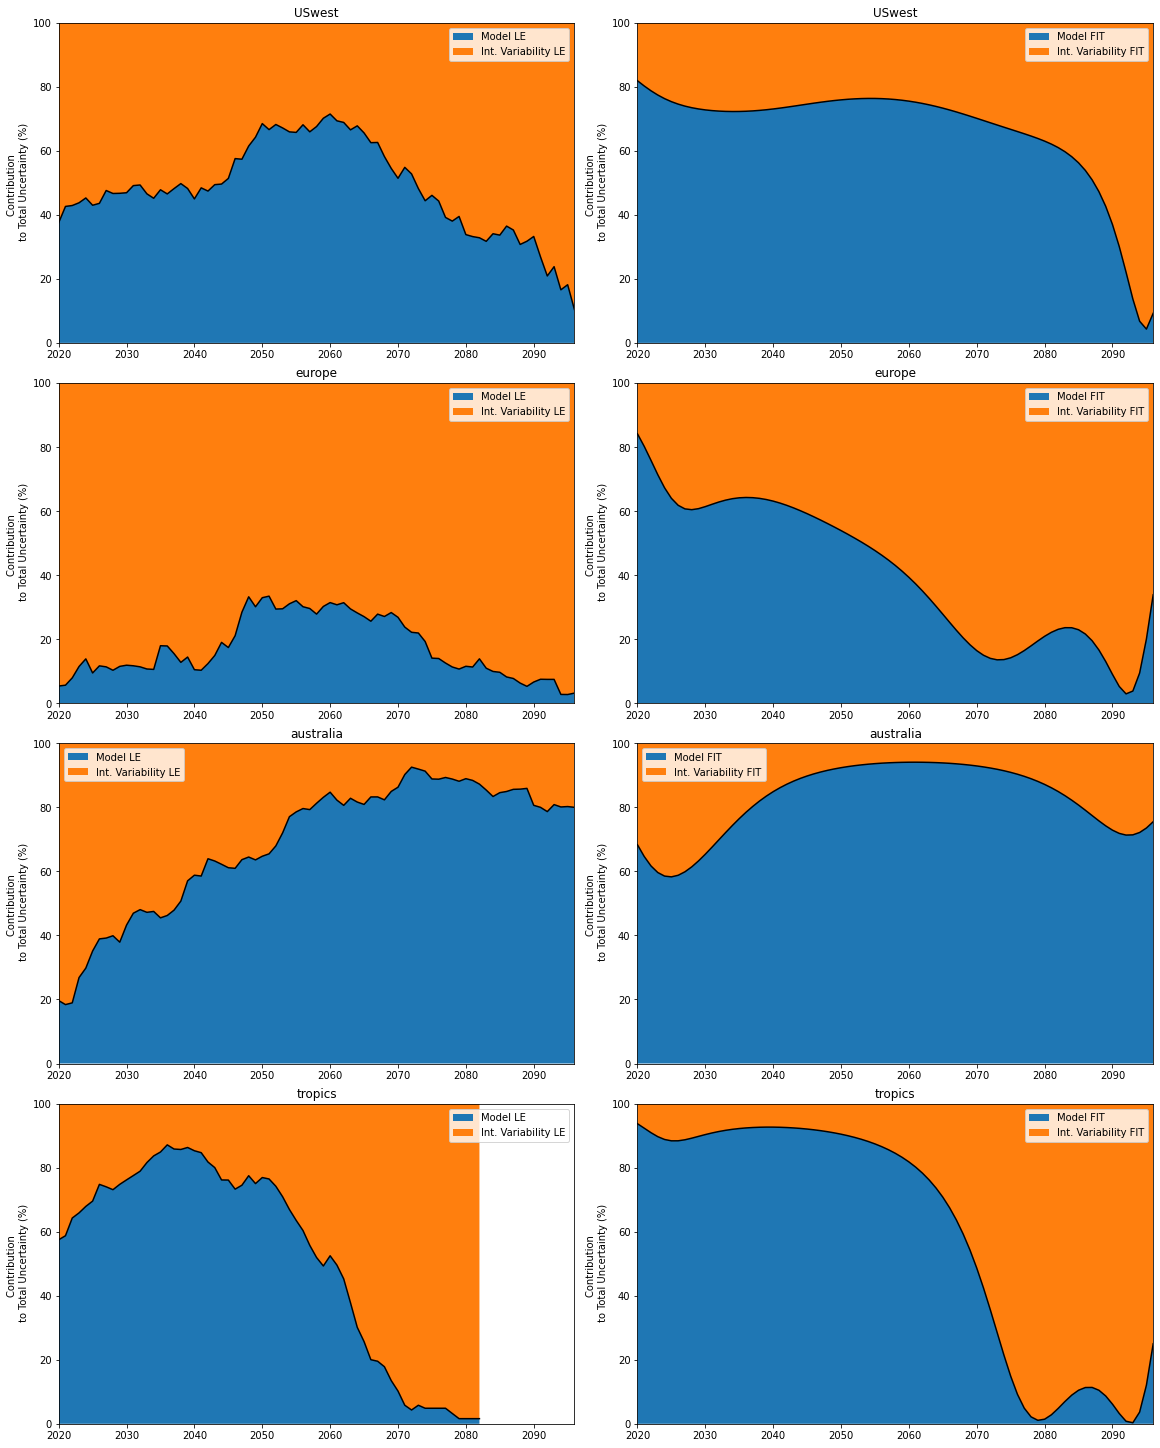

In [26]:
# INTERNAL EXTREME MAX
fig,ax = plt.subplots(nrows=4,ncols=2, constrained_layout=True,figsize=(16,20))

regions = ['USwest','europe','australia','tropics']
axes = [ax[0,0],ax[1,0],ax[2,0],ax[3,0]]
for axis,region in zip(axes,regions):
    x=extreme_max.sel(region=region).time
    y=extreme_max.sel(region=region).model_le_frac
    axis.fill_between(x,y,label='Model LE')
    axis.plot(extreme_max.sel(region=region).time,extreme_max.sel(region=region).model_le_frac,color='k')
    axis.fill_between(x,y,100,label='Int. Variability LE')
    axis.set_ylim(0,100)
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[5],x[-5])
    
axes = [ax[0,1],ax[1,1],ax[2,1],ax[3,1]]
for axis,region in zip(axes,regions):
    x=extreme_max.sel(region=region).time
    y=extreme_max.sel(region=region).model_fit_frac
    axis.fill_between(x,y,label='Model FIT')
    axis.plot(extreme_max.sel(region=region).time,extreme_max.sel(region=region).model_fit_frac,color='k')
    axis.fill_between(x,y,100,label='Int. Variability FIT')
    axis.set_ylim(0,100)
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[5],x[-5])

### load scenario data 

In [8]:
# models that have all four scenarios 
models = ['CESM2-WACCM','CMCC-CM2-SR5','CMCC-ESM2',
          'EC-Earth3','EC-Earth3-Veg-LR','GFDL-ESM4','IITM-ESM','INM-CM4-8','INM-CM5-0',
          'IPSL-CM6A-LR','KACE-1-0-G','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','NorESM2-MM']

In [13]:
ssp126_USwest = MultiModelLargeEnsemble(models=models, scenario='ssp126',
                                 variable='tas', granularity='day', lat=37.7, lon=-122.4,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)
ssp245_USwest = MultiModelLargeEnsemble(models=models, scenario='ssp245',
                                 variable='tas', granularity='day', lat=37.7, lon=-122.4,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

ssp370_USwest = MultiModelLargeEnsemble(models=models, scenario='ssp370',
                                 variable='tas', granularity='day', lat=37.7, lon=-122.4,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

ssp585_USwest = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable='tas', granularity='day', lat=37.7, lon=-122.4,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)



In [16]:
ssp126_europe = MultiModelLargeEnsemble(models=models, scenario='ssp126',
                                 variable='tas', granularity='day', lat=51,lon=10.5,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)
ssp245_europe = MultiModelLargeEnsemble(models=models, scenario='ssp245',
                                 variable='tas', granularity='day', lat=51,lon=10.5,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

ssp370_europe = MultiModelLargeEnsemble(models=models, scenario='ssp370',
                                 variable='tas', granularity='day', lat=51,lon=10.5,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

ssp585_europe = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable='tas', granularity='day', lat=51,lon=10.5,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

In [24]:
ssp126_australia = MultiModelLargeEnsemble(models=models, scenario='ssp126',
                                 variable='tas', granularity='day', lat=-25.2,lon=133.7,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)
ssp245_australia = MultiModelLargeEnsemble(models=models, scenario='ssp245',
                                 variable='tas', granularity='day', lat=-25.2,lon=133.7,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

ssp370_australia = MultiModelLargeEnsemble(models=models, scenario='ssp370',
                                 variable='tas', granularity='day', lat=-25.2,lon=133.7,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

ssp585_australia = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable='tas', granularity='day', lat=-25.2,lon=133.7,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

In [25]:
ssp126_tropics = MultiModelLargeEnsemble(models=models, scenario='ssp126',
                                 variable='tas', granularity='day', lat=3.9,lon=-53.1,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)
ssp245_tropics = MultiModelLargeEnsemble(models=models, scenario='ssp245',
                                 variable='tas', granularity='day', lat=3.9,lon=-53.1,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

ssp370_tropics = MultiModelLargeEnsemble(models=models, scenario='ssp370',
                                 variable='tas', granularity='day', lat=3.9,lon=-53.1,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

ssp585_tropics = MultiModelLargeEnsemble(models=models, scenario='ssp585',
                                 variable='tas', granularity='day', lat=3.9,lon=-53.1,
                                 bucket='climateai_data_repository', path='tmp/internal_variability',
                                 load=True, single_member=True)

In [34]:
# this function is not working ! 

# def compute_scenario_allregions():
#     regions = ['USwest','europe','australia','tropics']
#     dss = []
#     for r in regions:
#         exec('scenario = ssp126_'+r+'.compute_scenario(ssp126_'+r+',ssp245_'+r+',ssp370_'+r+',ssp585_'+r+')')
#         scenario = scenario.expand_dims('region')
#         dss.append(scenario)
#     final_dataset = xr.concat(dss,dim='region')
#     final_dataset = final_dataset.assign_coords({'region':regions})
    
#     return final_dataset

In [36]:
# scenario = compute_scenario_allregions()

In [41]:
#works here, does not work in function above 
regions = ['USwest','europe','australia','tropics']
dss = []
dss1 = []
for r in regions:
    exec('scenario_uncertainty = ssp126_'+r+'.compute_scenario(ssp126_'+r+',ssp245_'+r+',ssp370_'+r+',ssp585_'+r+')[0]')
    scenario_uncertainty = scenario_uncertainty.expand_dims('region')
    dss.append(scenario_uncertainty)
    exec('scenario = ssp126_'+r+'.compute_scenario(ssp126_'+r+',ssp245_'+r+',ssp370_'+r+',ssp585_'+r+')[1]')
    scenario = scenario.expand_dims('region')
    dss1.append(scenario)
final_dataset = xr.concat(dss,dim='region')
final_dataset1 = xr.concat(dss1,dim='region')
scenario_uncertainty = final_dataset.assign_coords({'region':regions})
scenario = final_dataset1.assign_coords({'region':regions})

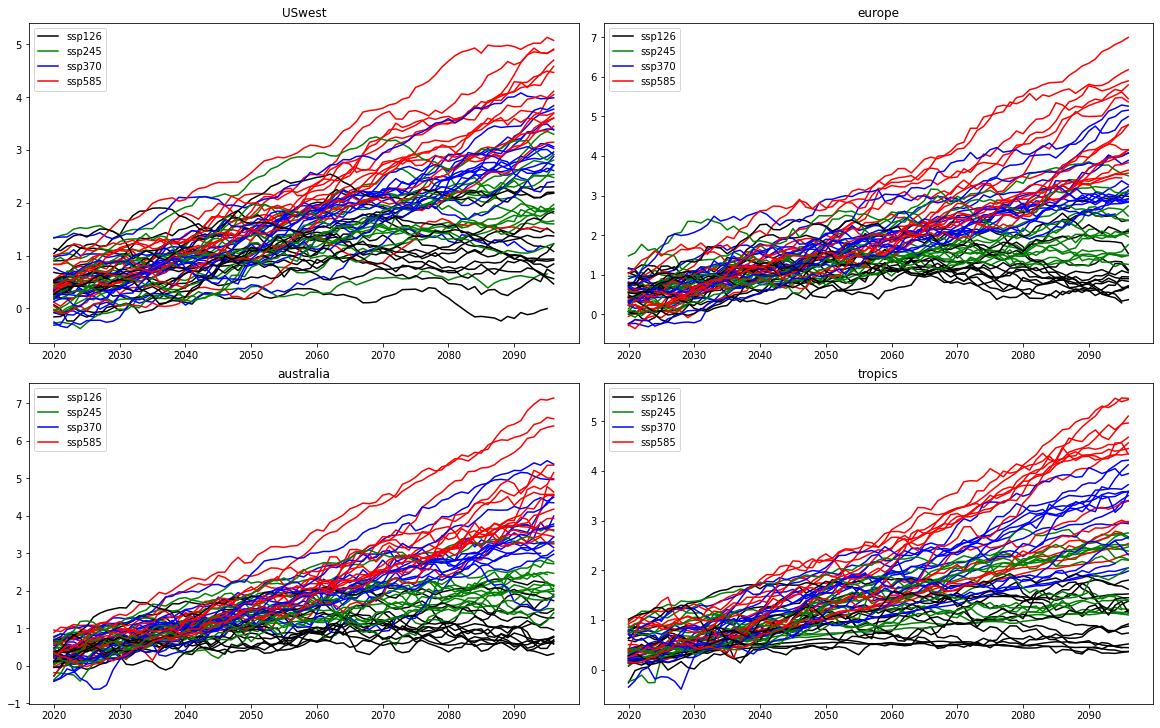

In [59]:
# scenario plots with all models 
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
# colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
colors = ['k','r','b','g']
for m in range(len(scenario.model)):
    for axe,r in zip(axes,regions):
        axe.plot(scenario.sel(region=r).time,
                 scenario.sel(region=r).isel(model=m).sel(scenario='ssp126').tas,color='k')
        axe.plot(scenario.sel(region=r).time,
                 scenario.sel(region=r).isel(model=m).sel(scenario='ssp245').tas,color='g')
        axe.plot(scenario.sel(region=r).time,
                 scenario.sel(region=r).isel(model=m).sel(scenario='ssp370').tas,color='b')
        axe.plot(scenario.sel(region=r).time,
                 scenario.sel(region=r).isel(model=m).sel(scenario='ssp585').tas,color='r')
        # axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        labels = ['ssp126','ssp245','ssp370','ssp585']
        axe.legend(labels=labels)
    # axe.set_ylim(0,40)

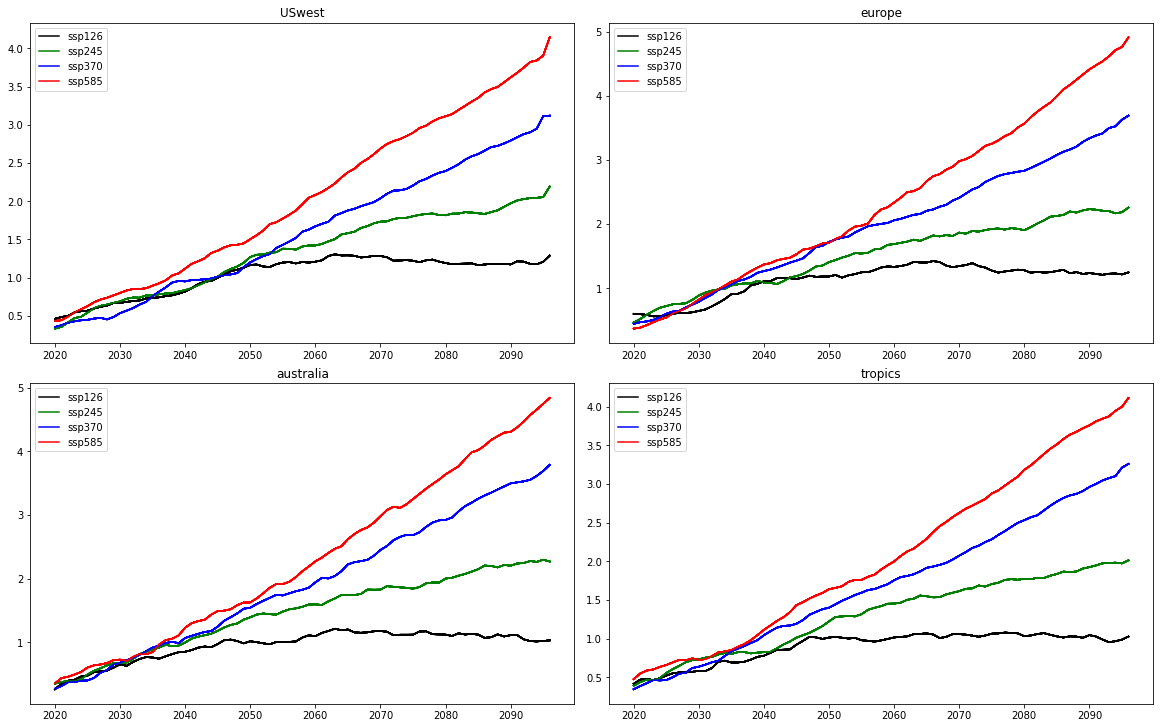

In [60]:
# scenario plots - model means 
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
# colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
colors = ['k','r','b','g']
for m in range(len(scenario.model)):
    for axe,r in zip(axes,regions):
        axe.plot(scenario.sel(region=r).time,
                 scenario.sel(region=r).isel(model=m).sel(scenario='ssp126').tasmean,color='k')
        axe.plot(scenario.sel(region=r).time,
                 scenario.sel(region=r).isel(model=m).sel(scenario='ssp245').tasmean,color='g')
        axe.plot(scenario.sel(region=r).time,
                 scenario.sel(region=r).isel(model=m).sel(scenario='ssp370').tasmean,color='b')
        axe.plot(scenario.sel(region=r).time,
                 scenario.sel(region=r).isel(model=m).sel(scenario='ssp585').tasmean,color='r')
        # axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        labels = ['ssp126','ssp245','ssp370','ssp585']
        axe.legend(labels=labels)
    # axe.set_ylim(0,40)

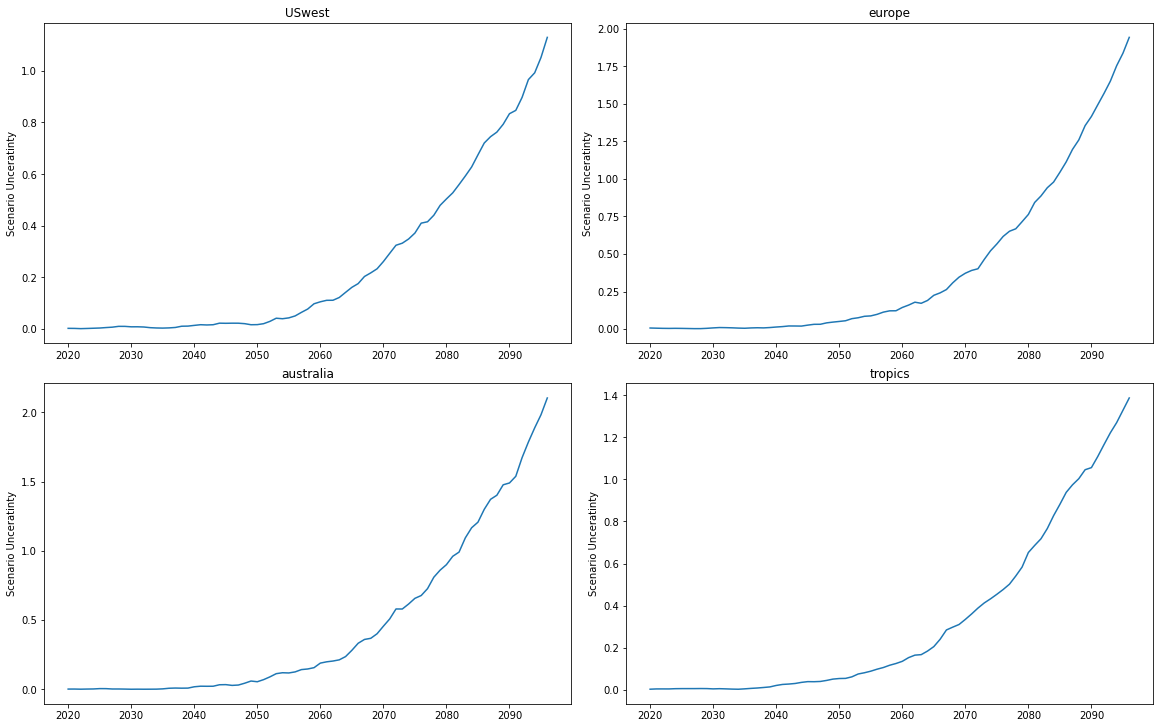

In [62]:
# scenario uncertainty 
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
# colors = sns.color_palette("inferno", len(test_conseq.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    axe.plot(scenario_uncertainty.sel(region=r).time,scenario_uncertainty.sel(region=r))
    axe.set_ylabel('Scenario Unceratinty')
    axe.set_title(r)
    # axe.set_ylim(0,40)

In [82]:
# make copy of dataset 
internal_mean_scenario = internal_mean.copy()

In [83]:
# redefine variables with scenario included 
internal_mean_scenario['total_le'] = internal_mean_scenario.model_le + internal_mean_scenario.internal_mean_le + scenario_uncertainty 
internal_mean_scenario['total_fit'] = internal_mean_scenario.model_fit + internal_mean_scenario.internal_mean_fit + scenario_uncertainty 
internal_mean_scenario['model_le_frac'] = (internal_mean_scenario.model_le/internal_mean_scenario.total_le)*100
internal_mean_scenario['model_fit_frac'] = (internal_mean_scenario.model_fit/internal_mean_scenario.total_fit)*100
internal_mean_scenario['internal_le_frac'] = (internal_mean_scenario.internal_mean_le/internal_mean_scenario.total_le)*100
internal_mean_scenario['internal_fit_frac'] = (internal_mean_scenario.internal_mean_fit/internal_mean_scenario.total_fit)*100
internal_mean_scenario['scenario_le_frac'] = (scenario_uncertainty/internal_mean_scenario.total_le)*100
internal_mean_scenario['scenario_fit_frac'] = (scenario_uncertainty/internal_mean_scenario.total_fit)*100





In [84]:
internal_mean_scenario

<xarray.Dataset>
Dimensions:            (time: 86, model: 5, region: 4, member: 58)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    member_id          (member, model) object 'r16i1p2f1' 1.0 ... nan 'r3i1p1f1'
  * region             (region) <U9 'USwest' 'europe' 'australia' 'tropics'
Data variables: (12/19)
    tas_ref            (region, model) float32 15.79 14.98 16.45 ... 27.69 26.09
    tas                (region, time, member, model) float32 nan nan ... nan nan
    model_le           (region, time) float32 nan nan nan nan ... nan nan nan
    internal_mean_le   (region, time) float32 nan nan nan nan ... nan nan nan
    internal_var_le    (region, time) float32 nan nan nan nan ... nan nan nan
    total_le           (region, time) float32 nan nan nan nan ... nan nan nan
    ...                 ...
    total_fit          (region, time) float32 nan nan nan nan ... nan nan nan
    internal_fit_frac  (region, time) float32 nan nan nan nan ... nan nan nan
    model_fit_frac     (region, time) float32 nan nan nan nan ... nan nan nan
    total_direct_fit   (region, time) float32 nan nan nan nan ... nan nan nan
    scenario_le_frac   (region, time) float32 nan nan nan nan ... nan nan nan
    scenario_fit_frac  (region, time) float32 nan nan nan nan ... nan nan nan

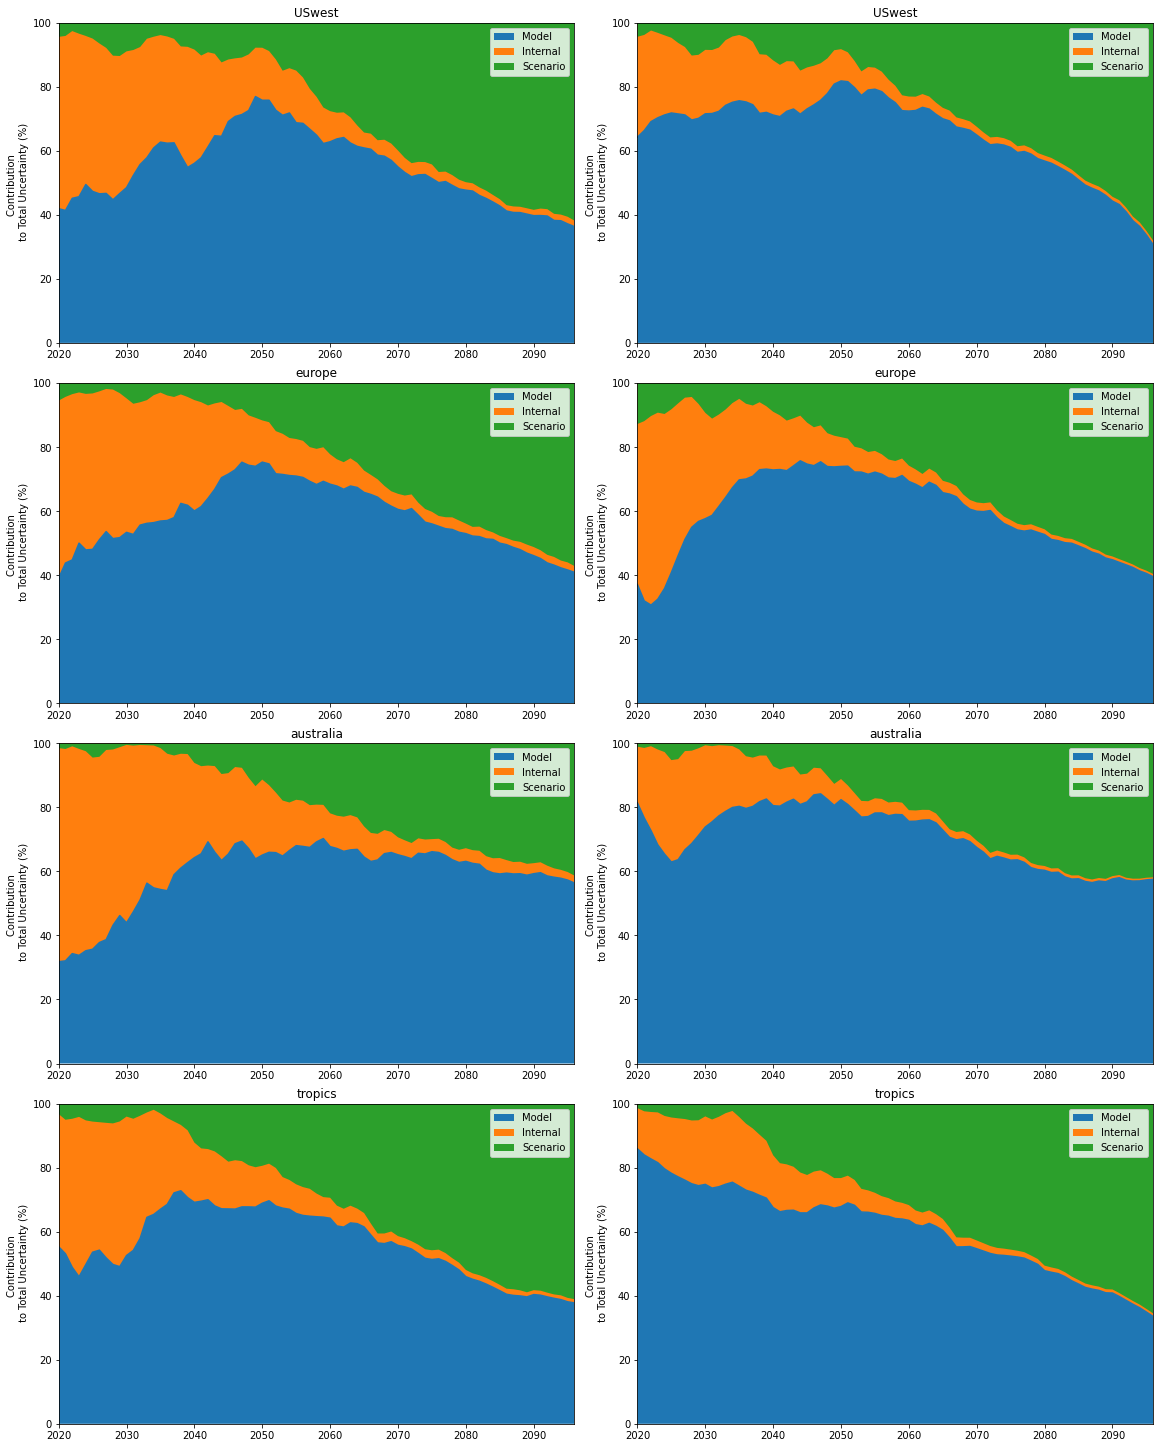

In [86]:
# INTERNAL MEAN WITH SCENARIO 
# LE Method on left, FIT method on right 
fig,ax = plt.subplots(nrows=4,ncols=2, constrained_layout=True,figsize=(16,20))

regions = ['USwest','europe','australia','tropics']
axes = [ax[0,0],ax[1,0],ax[2,0],ax[3,0]]
for axis,region in zip(axes,regions):
    x=internal_mean_scenario.sel(region=region).time
    y=internal_mean_scenario.sel(region=region).model_le_frac
    y1 = internal_mean_scenario.sel(region=region).internal_le_frac
    y2 = internal_mean_scenario.sel(region=region).scenario_le_frac
    axis.set_ylim(0,100)
    axis.plot(x,y)
    axis.fill_between(x,y,label='Model')
    axis.fill_between(x,y,100,label='Internal')
    axis.fill_between(x,100-y2,100,label='Scenario')
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[5],x[-5])
    
axes = [ax[0,1],ax[1,1],ax[2,1],ax[3,1]]
for axis,region in zip(axes,regions):
    x=internal_mean_scenario.sel(region=region).time
    y=internal_mean_scenario.sel(region=region).model_fit_frac
    y1 = internal_mean_scenario.sel(region=region).internal_fit_frac
    y2 = internal_mean_scenario.sel(region=region).scenario_fit_frac
    axis.set_ylim(0,100)
    axis.plot(x,y)
    axis.fill_between(x,y,label='Model')
    axis.fill_between(x,y,100,label='Internal')
    axis.fill_between(x,100-y2,100,label='Scenario')
    axis.set_ylabel('Contribution \n to Total Uncertainty (%)')
    axis.legend()
    axis.set_title(region)
    axis.set_xlim(x[5],x[-5])

In [69]:
test_return

<xarray.Dataset>
Dimensions:            (time: 86, member: 58, model: 5, concat_dim: 5, region: 4)
Coordinates:
  * time               (time) datetime64[ns] 2015-01-01 ... 2100-01-01
  * member             (member) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    member_id          (model, member) object 'r16i1p2f1' ... 'r3i1p1f1'
  * model              (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
    quantile           (concat_dim) float64 0.9995 0.9997 0.9999 0.9999 1.0
  * concat_dim         (concat_dim) int64 5 10 20 50 100
  * region             (region) <U9 'USwest' 'europe' 'australia' 'tropics'
Data variables: (12/17)
    tas_occurance      (region, concat_dim, model, member, time) float64 nan ...
    model_le           (region, concat_dim, time) float64 nan nan ... nan nan
    internal_mean_le   (region, concat_dim, time) float64 nan nan ... nan nan
    internal_var_le    (region, concat_dim, time) float64 nan nan ... nan nan
    total_le           (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_le    (region, concat_dim, time) float64 nan nan ... nan nan
    ...                 ...
    model_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    total_fit          (region, concat_dim, time) float64 nan nan ... nan nan
    internal_fit_frac  (region, concat_dim, time) float64 nan nan ... nan nan
    model_fit_frac     (region, concat_dim, time) float64 nan nan ... nan nan
    total_direct_fit   (region, concat_dim, time) float64 nan nan ... nan nan
    MTratio            (region, concat_dim, time) float64 nan nan ... nan nan

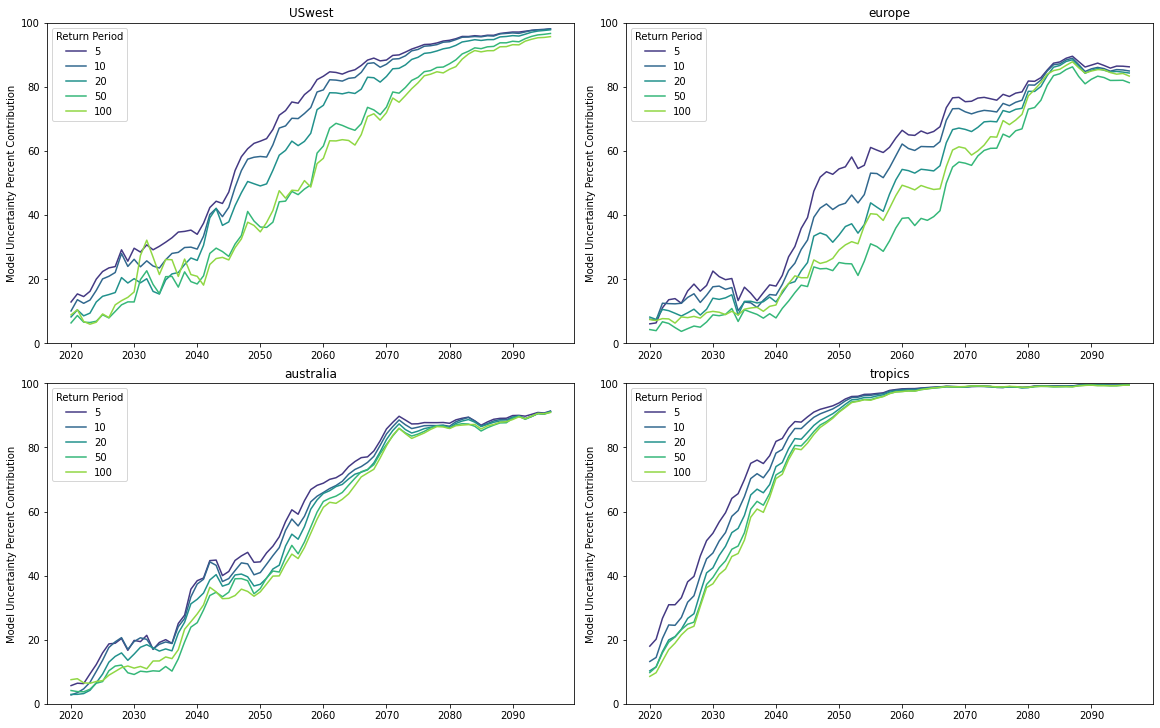

In [71]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("viridis", len(test_return.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_return.concat_dim):
        axe.plot(test_return.sel(region=r,concat_dim=m).time,test_return.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['5','10','20','50','100']
        axe.legend(labels=labels,loc=2,title='Return Period')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)
        

For temp: greater internal variability for larger return periods. US west and Europe have largest spreads. Convergence towards the end of the century for all return periods when model uncertainty dominates. This point is reached much earlier for the tropics. 

In [72]:
test_coarsen = sensitivity_allregions(parameter='coarsen',
                                    args = {'return_period':10,
                                            'coarsen':[1,3,5,7],
                                            'conseq_days':1,
                                            'rolling_average':10,
                                            'hist_slice':slice('1995','2014'),
                                            'postprocess':True
                                           })

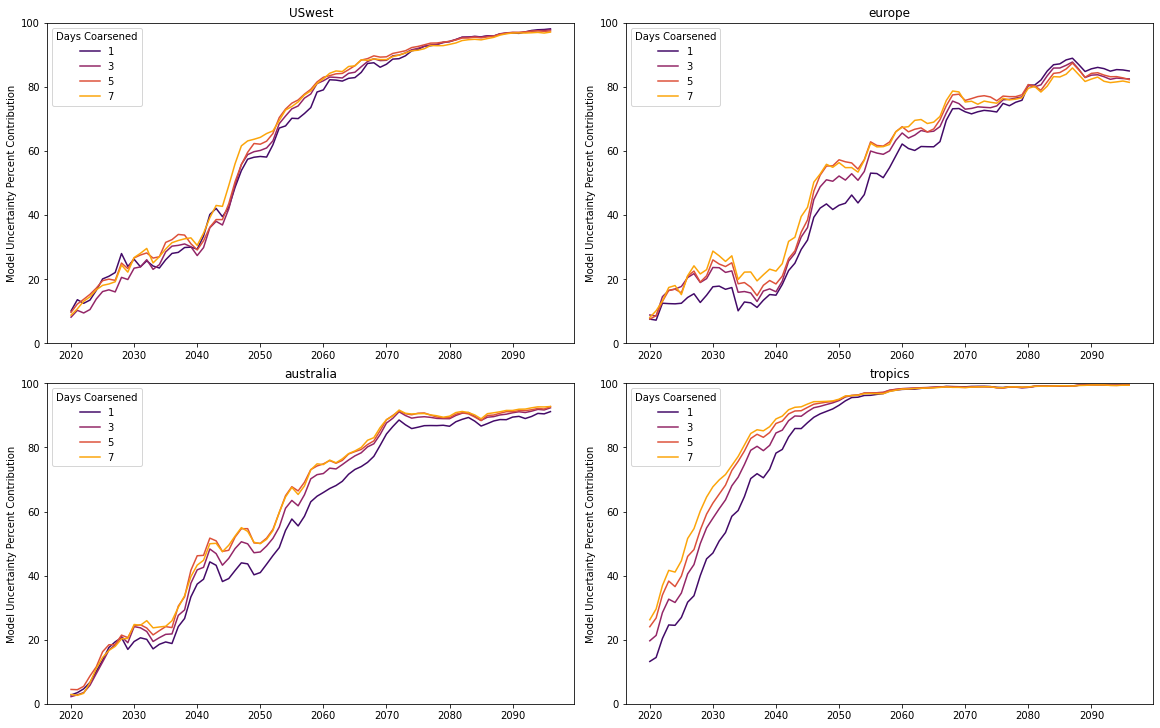

In [74]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_coarsen.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_coarsen.concat_dim):
        axe.plot(test_coarsen.sel(region=r,concat_dim=m).time,test_coarsen.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','3','5','7']
        axe.legend(labels=labels,loc=2,title='Days Coarsened')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)
        

In [78]:
test_rolling = sensitivity_allregions(parameter='rolling_average',
                                        args = {'return_period':10,
                                                'coarsen':1,
                                                'conseq_days':1,
                                                'rolling_average':[1,5,10,15,20],
                                                'hist_slice':slice('1995','2014'),
                                                'postprocess':True
                                               }
                                     )

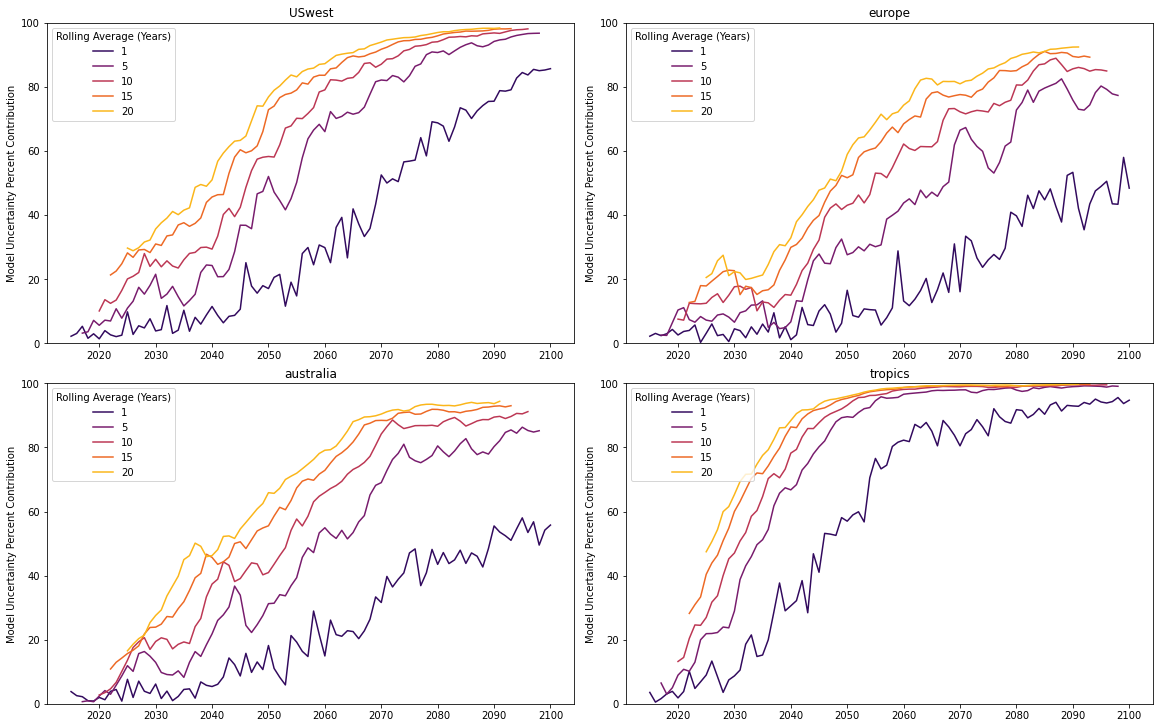

In [80]:
fig,ax = plt.subplots(nrows=2,ncols=2,constrained_layout=True,figsize=(16,10))
colors = sns.color_palette("inferno", len(test_rolling.concat_dim))
axes = [ax[0,0],ax[0,1],ax[1,0],ax[1,1]]
regions = ['USwest','europe','australia','tropics']
for axe,r in zip(axes,regions):
    for i,m in enumerate(test_rolling.concat_dim):
        axe.plot(test_rolling.sel(region=r,concat_dim=m).time,test_rolling.sel(region=r,concat_dim=m).model_le_frac,
                c=colors[i])
        labels=['1','5','10','15','20']
        axe.legend(labels=labels,loc=2,title='Rolling Average (Years)')
        axe.set_ylabel('Model Uncertainty Percent Contribution')
        axe.set_title(r)
        axe.set_ylim(0,100)
        # print(i)
        # model_frac = test_return.sel(region=r).model_le_frac
        # model_frac.plot(hue='concat_dim',c=colors[i],ax=axe,add_legend=False)